In [12]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import RemoveMessage

In [13]:
from langchain_openai import ChatOpenAI
import re
model: ChatOpenAI = ChatOpenAI(
    base_url="http://127.0.0.1:1234/v1",
    temperature=0,
    api_key="not-needed"
)

pattern = r"<think>[\s\S]*?<\/think>"


## State

In [14]:
class State(MessagesState):
    summarize = str

## Node

In [15]:
def call_model(state: State):

    summary = state.get("summarize", "")
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

In [16]:
def summarize_conversation(state: State):
    summary = state.get("summarize", "")
    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = f"Create a summary of the conversation above:"

    messages = [HumanMessage(content=summary_message)] + state["messages"] 

    response = model.invoke(messages)
    response = re.sub(pattern, "", response.content)
    delete_msg = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    return {"messages": delete_msg, "summarize": response}

In [17]:
from langgraph.graph import END
# Determine whether to end or summarize the conversation
def should_continue(state: State):
    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

## Build graph

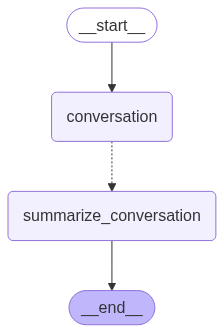

In [22]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Tạo graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

# Bắt đầu từ START → gọi node "conversation"
workflow.add_edge(START, "conversation")

# Ở node "conversation", tùy kết quả của should_continue:
#   - nếu trả về "summarize_conversation" thì đi vào node đó
#   - nếu trả về END thì kết thúc
workflow.add_conditional_edges(
    "conversation",
    should_continue,
    {
        "summarize_conversation": "summarize_conversation",
        END: END
    }
)

# Sau khi xong summarize, quay về END
workflow.add_edge("summarize_conversation", END)

# Compile và vẽ
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

<think>
Okay, the user said "hi! I'm Lance." So they're introducing themselves as Lance. I need to respond in a friendly and helpful way.

First, I should acknowledge their greeting. Maybe say something like "Hello!" or "Hi there!" to keep it open.

Then, since they mentioned being Lance, I can ask how they're doing or if they have any questions. That's a good way to invite them to ask anything.

I should make sure the response is concise and not too long. Keep it simple and welcoming.

Also, check for any possible follow-up questions they might have. Maybe offer assistance with anything related to their interests or tasks.

Avoid using technical jargon unless they mention it. Stay conversational.

Alright, putting it all together: a friendly greeting, an invitation to ask questions, and a positive tone.
</think>

Hello! I'm Lance. How can I assist you today? 😊
================================== Ai Messag

In [20]:
input_message = HumanMessage(
    content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

<think>
Okay, the user mentioned they like Nick Bosa and that he's the highest-paid defensive player. I need to respond appropriately.

First, I should confirm their interest in Nick Bosa. Then, address the part about him being the highest-paid defensive player. I should check if that's accurate. Wait, as of 2023, Nick Bosa is indeed one of the top earners in the NFL, but he's not the highest paid defensive player. The highest would be maybe someone like Justin Jefferson or other wide receivers. But the user might not know that.

I need to present this information accurately without making it sound like I'm contradicting them. Maybe explain that while Bosa is a top-tier player, there are others with higher salaries in the league. Also, acknowledge their interest and offer to discuss more about him or other players they enjoy.

Make sure the tone is friendly and helpful. Encourage them to ask questions if 

In [21]:
graph.get_state(config).values.get("summary", "")

''